### Home work № 3:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from scipy.sparse import hstack
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.pipeline import FeatureUnion, Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

In [2]:
df = pd.read_csv('train_case2.csv', ';')
df.head(3)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1


##### Разделим наши данные на тренировочную и тестовую выборки

In [3]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('cardio', 1), df['cardio'], random_state=0)

In [4]:
X_train.shape

(52500, 12)

##### Сделаем feature encoding:
- gender, cholesterol применим OHE-кодирование
- age, height, weight, ap_hi, ap_lo - standardScaler
- gluc, smoke, alco, active - оставим пока как есть

In [5]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in test_columns:
            if col_ not in self.columns:
                X[col_] = 0
        return X[self.columns]

In [6]:
continuos_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
cat_cols = ['gender', 'cholesterol']
base_cols = ['gluc', 'smoke', 'alco', 'active']

continuos_transformers = []
cat_transformers = []
base_transformers = []

In [7]:
for cont_col in continuos_cols:
    transfomer =  Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    continuos_transformers.append((cont_col, transfomer))
    
for cat_col in cat_cols:
    cat_transformer = Pipeline([
                ('selector', ColumnSelector(key=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    cat_transformers.append((cat_col, cat_transformer))
    
for base_col in base_cols:
    base_transformer = Pipeline([
                ('selector', NumberSelector(key=base_col))
            ])
    base_transformers.append((base_col, base_transformer))

##### Объединим все трансформеры с помощью FeatureUnion

In [8]:
feats = FeatureUnion(continuos_transformers+cat_transformers+base_transformers)

#### Task № 2: При обучении моделей обязательно использовать кроссвалидацию.

##### Добавим классификаторы и запустим кросс-валидацию

In [9]:
%%time

classifier_LR = Pipeline([
    ('features',feats),
    ('classifier', LogisticRegression(C = 10,random_state = 42)),
])

classifier_GBC = Pipeline([
    ('features',feats),
    ('classifier', GradientBoostingClassifier(random_state = 42)),
])

classifier_XGBC = Pipeline([
    ('features',feats),
    ('classifier', XGBClassifier(eval_metric = 'logloss', use_label_encoder=False, random_state = 42)),
])

classifier_LGBMC = Pipeline([
    ('features',feats),
    ('classifier', LGBMClassifier(random_state = 42)),
])

classifier_CBC = Pipeline([
    ('features',feats),
    ('classifier', CatBoostClassifier(verbose = 0, n_estimators=100, random_state = 42)),
])


classifier_DTC = Pipeline([
    ('features',feats),
    ('classifier', DecisionTreeClassifier(max_depth=11, random_state = 42)),
])

#запустим кросс-валидацию
cv_scores_LR = cross_val_score(classifier_LR, X_train, y_train, cv=6, scoring='roc_auc_ovo')
cv_score_LR = np.mean(cv_scores_LR)
cv_score_LR_std = np.std(cv_scores_LR)
print(f'LR CV score is {cv_score_LR}+-{cv_score_LR_std}')
                       
cv_scores_GBC = cross_val_score(classifier_GBC, X_train, y_train, cv=6, scoring='roc_auc_ovo')
cv_score_GBC = np.mean(cv_scores_GBC)
cv_score_GBC_std = np.std(cv_scores_GBC)
print('GBC CV score is {}+-{}'.format(cv_score_GBC, cv_score_GBC_std))                       
                       
cv_scores_XGBC = cross_val_score(classifier_XGBC, X_train, y_train, cv=6, scoring='roc_auc_ovo')
cv_score_XGBC = np.mean(cv_scores_XGBC)
cv_score_XGBC_std = np.std(cv_scores_XGBC)
print('XGBC CV score is {}+-{}'.format(cv_score_XGBC, cv_score_XGBC_std))                          
                       
cv_scores_LGBMC = cross_val_score(classifier_LGBMC, X_train, y_train, cv=6, scoring='roc_auc_ovo')
cv_score_LGBMC = np.mean(cv_scores_LGBMC)
cv_score_LGBMC_std = np.std(cv_scores_LGBMC)
print('LGBMC CV score is {}+-{}'.format(cv_score_LGBMC, cv_score_LGBMC_std))                                
                       
cv_scores_CBC = cross_val_score(classifier_CBC, X_train, y_train, cv=6, scoring='roc_auc_ovo')
cv_score_CBC = np.mean(cv_scores_CBC)
cv_score_CBC_std = np.std(cv_scores_CBC)
print('CBC CV score is {}+-{}'.format(cv_score_CBC, cv_score_CBC_std))                           
                       
cv_scores_DTC = cross_val_score(classifier_DTC, X_train, y_train, cv=6, scoring='roc_auc_ovo')
cv_score_DTC = np.mean(cv_scores_DTC)
cv_score_DTC_std = np.std(cv_scores_DTC)
print('DTC CV score is {}+-{}'.format(cv_score_DTC, cv_score_DTC_std))                                      

LR CV score is 0.7868697996061201+-0.004835281690267352
GBC CV score is 0.8023377962657184+-0.004150757612691979
XGBC CV score is 0.7969315098544917+-0.0034994118193665863
LGBMC CV score is 0.8018913054138396+-0.003990232250427125
CBC CV score is 0.8017301512196573+-0.004294836693159835
DTC CV score is 0.7709512383585603+-0.0043375163971778865
Wall time: 39.8 s


#### Task № 1: Обучить несколько разных моделей на наборе данных ССЗ (train_case2.csv): логрег, бустинг, лес и т.д - на ваш выбор 2-3 варианта.

##### Обучим пайплайны на всем тренировочном датасете

In [10]:
%%time

classifier_LR.fit(X_train, y_train)
y_score_LR = classifier_LR.predict_proba(X_test)[:, 1]

classifier_GBC.fit(X_train, y_train)
y_score_GBC = classifier_GBC.predict_proba(X_test)[:, 1]

classifier_XGBC.fit(X_train, y_train)
y_score_XGBC = classifier_XGBC.predict_proba(X_test)[:, 1]

classifier_LGBMC.fit(X_train, y_train)
y_score_LGBMC = classifier_LGBMC.predict_proba(X_test)[:, 1]

classifier_CBC.fit(X_train, y_train)
y_score_CBC = classifier_CBC.predict_proba(X_test)[:, 1]

classifier_DTC.fit(X_train, y_train)
y_score_DTC = classifier_DTC.predict_proba(X_test)[:, 1]

Wall time: 6.77 s


#### Task № 3: Вывести сравнение полученных моделей по основным метрикам классификации.

##### Посчитаем precision/recall/f_score

In [11]:
%%time

b=1

precision_LR, recall_LR, thresholds_LR = precision_recall_curve(y_test.values, y_score_LR)
fscore_LR = (1+b**2)*(precision_LR * recall_LR) / (b**2*precision_LR + recall_LR)
# locate the index of the largest f score
ix = np.argmax(fscore_LR)
t_LR = thresholds_LR[ix]
print('LR Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (t_LR, fscore_LR[ix], 
                                                                           precision_LR[ix], recall_LR[ix]))

precision_GBC, recall_GBC, thresholds_GBC = precision_recall_curve(y_test.values, y_score_GBC)
fscore_GBC = (1+b**2)*(precision_GBC * recall_GBC) / (b**2*precision_GBC + recall_GBC)
ix = np.argmax(fscore_GBC)
t_GBC = thresholds_GBC[ix]
print('GBC Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (t_GBC, fscore_GBC[ix], 
                                                                            precision_GBC[ix], recall_GBC[ix]))

precision_XGBC, recall_XGBC, thresholds_XGBC = precision_recall_curve(y_test.values, y_score_XGBC)
fscore_XGBC = (1+b**2)*(precision_XGBC * recall_XGBC) / (b**2*precision_XGBC + recall_XGBC)
ix = np.argmax(fscore_XGBC)
t_XGBC = thresholds_XGBC[ix]
print('XGBC Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (t_XGBC, fscore_XGBC[ix],
                                                                             precision_XGBC[ix], recall_XGBC[ix]))

precision_LGBMC, recall_LGBMC, thresholds_LGBMC = precision_recall_curve(y_test.values, y_score_LGBMC)
fscore_LGBMC = (1+b**2)*(precision_LGBMC * recall_LGBMC) / (b**2*precision_LGBMC + recall_LGBMC)
ix = np.argmax(fscore_LGBMC)
t_LGBMC = thresholds_LGBMC[ix]
print('LGBMC Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (t_LGBMC, fscore_LGBMC[ix], 
                                                                              precision_LGBMC[ix], recall_LGBMC[ix]))

precision_CBC, recall_CBC, thresholds_CBC = precision_recall_curve(y_test.values, y_score_CBC)
fscore_CBC = (1+b**2)*(precision_CBC * recall_CBC) / (b**2*precision_CBC + recall_CBC)
ix = np.argmax(fscore_CBC)
t_CBC = thresholds_CBC[ix]
print('CBC Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (t_CBC, fscore_CBC[ix], 
                                                                            precision_CBC[ix], recall_CBC[ix]))

precision_DTC, recall_DTC, thresholds_DTC = precision_recall_curve(y_test.values, y_score_DTC)
fscore_DTC = (1+b**2)*(precision_DTC * recall_DTC) / (b**2*precision_DTC + recall_DTC)
ix = np.argmax(fscore_DTC)
t_DTC = thresholds_DTC[ix]
print('DTC Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (t_DTC, fscore_DTC[ix], 
                                                                            precision_DTC[ix], recall_DTC[ix]))

LR Best Threshold=0.386133, F-Score=0.730, Precision=0.647, Recall=0.838
GBC Best Threshold=0.394947, F-Score=0.740, Precision=0.698, Recall=0.788
XGBC Best Threshold=0.347103, F-Score=0.738, Precision=0.665, Recall=0.828
LGBMC Best Threshold=0.344797, F-Score=0.740, Precision=0.661, Recall=0.840
CBC Best Threshold=0.369769, F-Score=0.740, Precision=0.680, Recall=0.813
DTC Best Threshold=0.320000, F-Score=0.725, Precision=0.649, Recall=0.822
Wall time: 30.9 ms


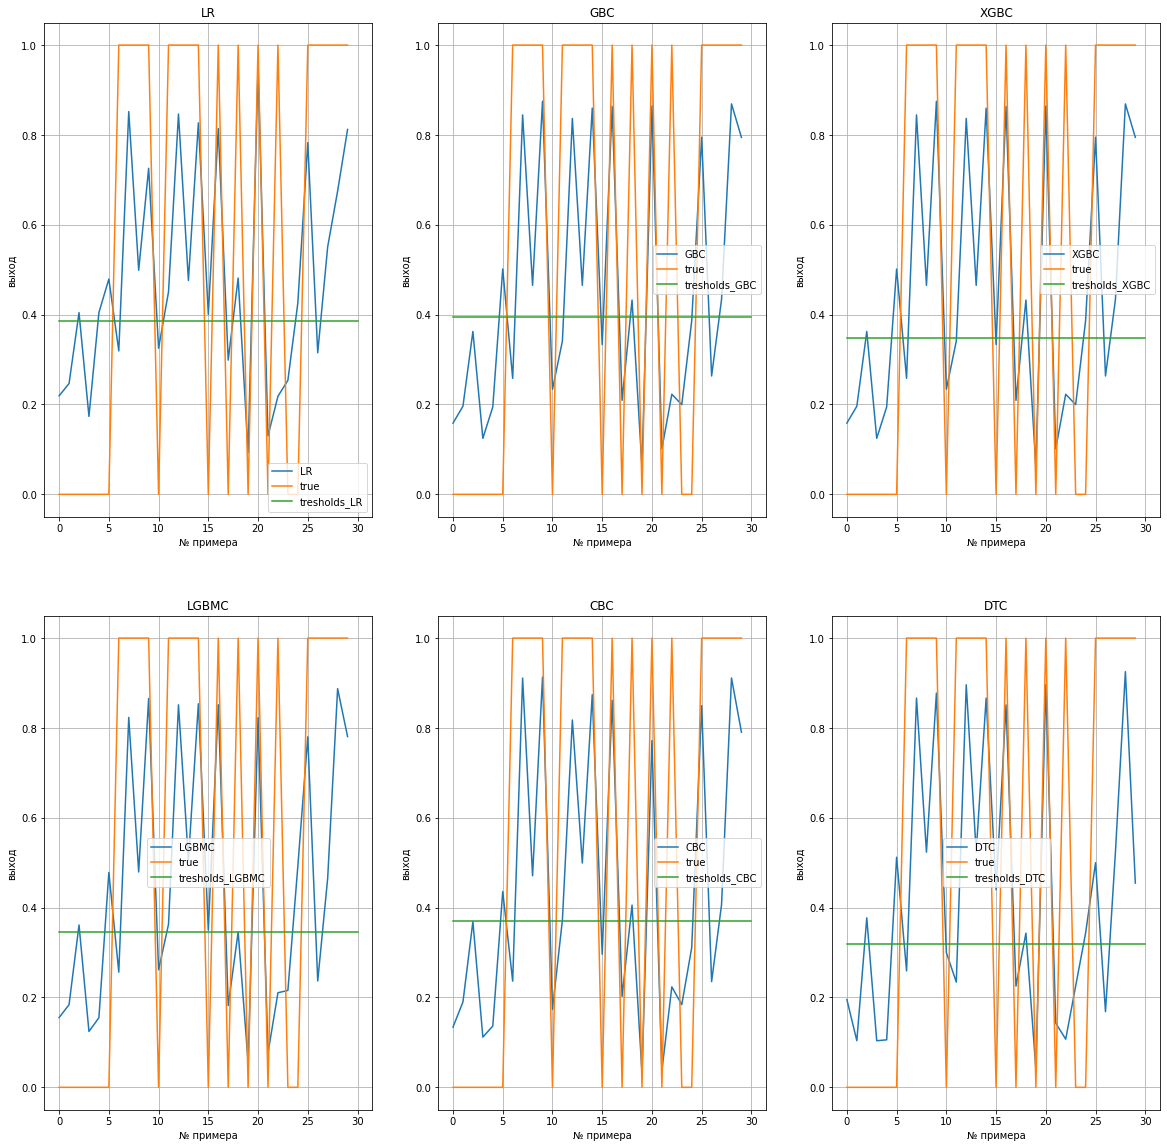

In [12]:
%matplotlib inline

fig, axes = plt.subplots(2, 3, figsize=(20, 20))

axes[0, 0].set_title('LR')
axes[0, 0].plot(y_score_LR[:30], label = 'LR')
axes[0, 0].plot(y_test.values[:30], label = 'true')
axes[0, 0].plot([0,30],[t_LR, t_LR], label = 'tresholds_LR')
axes[0, 0].set_ylabel('выход')
axes[0, 0].set_xlabel('№ примера')
axes[0, 0].grid()
axes[0, 0].legend()

axes[0, 1].set_title('GBC')
axes[0, 1].plot( y_score_GBC[:30], label = 'GBC')
axes[0, 1].plot(y_test.values[:30], label = 'true')
axes[0, 1].plot([0,30],[t_GBC, t_GBC], label = 'tresholds_GBC')
axes[0, 1].set_ylabel('выход')
axes[0, 1].set_xlabel('№ примера')
axes[0, 1].grid()
axes[0, 1].legend()

axes[0, 2].set_title('XGBC')
axes[0, 2].plot( y_score_GBC[:30], label = 'XGBC')
axes[0, 2].plot(y_test.values[:30], label = 'true')
axes[0, 2].plot([0,30],[t_XGBC, t_XGBC], label = 'tresholds_XGBC')
axes[0, 2].set_ylabel('выход')
axes[0, 2].set_xlabel('№ примера')
axes[0, 2].grid()
axes[0, 2].legend()

axes[1, 0].set_title('LGBMC')
axes[1, 0].plot( y_score_LGBMC[:30], label = 'LGBMC')
axes[1, 0].plot(y_test.values[:30], label = 'true')
axes[1, 0].plot([0,30],[t_LGBMC, t_LGBMC], label = 'tresholds_LGBMC')
axes[1, 0].set_ylabel('выход')
axes[1, 0].set_xlabel('№ примера')
axes[1, 0].grid()
axes[1, 0].legend()

axes[1, 1].set_title('CBC')
axes[1, 1].plot( y_score_CBC[:30], label = 'CBC')
axes[1, 1].plot(y_test.values[:30], label = 'true')
axes[1, 1].plot([0,30],[t_CBC, t_CBC], label = 'tresholds_CBC')
axes[1, 1].set_ylabel('выход')
axes[1, 1].set_xlabel('№ примера')
axes[1, 1].grid()
axes[1, 1].legend()

axes[1, 2].set_title('DTC')
axes[1, 2].plot( y_score_DTC[:30], label = 'DTC')
axes[1, 2].plot(y_test.values[:30], label = 'true')
axes[1, 2].plot([0,30],[t_DTC, t_DTC], label = 'tresholds_DTC')
axes[1, 2].set_ylabel('выход')
axes[1, 2].set_xlabel('№ примера')
axes[1, 2].grid()
axes[1, 2].legend()

fig.savefig("best_tresholds.jpg", dpi=300)

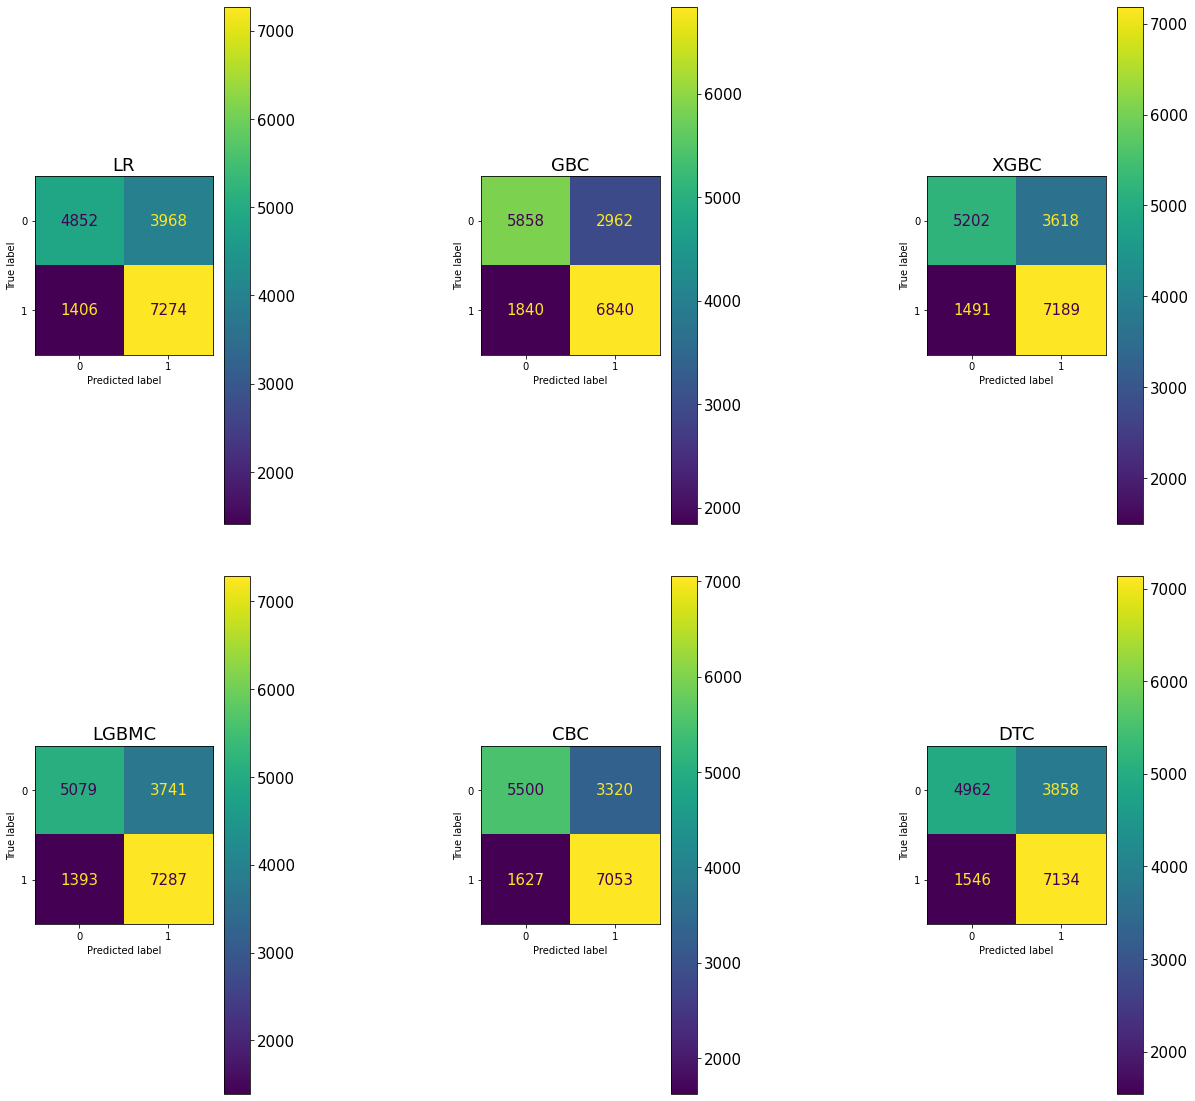

In [13]:
cnf_matrix = []
cnf_matrix.append(confusion_matrix(y_test, y_score_LR>t_LR))
cnf_matrix.append(confusion_matrix(y_test, y_score_GBC>t_GBC))
cnf_matrix.append(confusion_matrix(y_test, y_score_XGBC>t_XGBC))
cnf_matrix.append(confusion_matrix(y_test, y_score_LGBMC>t_LGBMC))
cnf_matrix.append(confusion_matrix(y_test, y_score_CBC>t_CBC))
cnf_matrix.append(confusion_matrix(y_test, y_score_DTC>t_DTC))
key = ['LR', 'GBC', 'XGBC', 'LGBMC', 'CBC', 'DTC']

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 20))
font = {'size' : 15}
plt.rc('font', **font)
for i in range(0,6):
    disp = ConfusionMatrixDisplay(cnf_matrix[i])
    disp.plot(ax=axes[i//3,i%3])
    disp.ax_.set_title(key[i])
plt.subplots_adjust(wspace=1, hspace=0.1)
plt.savefig("confusion_matrix.jpg")
plt.show()


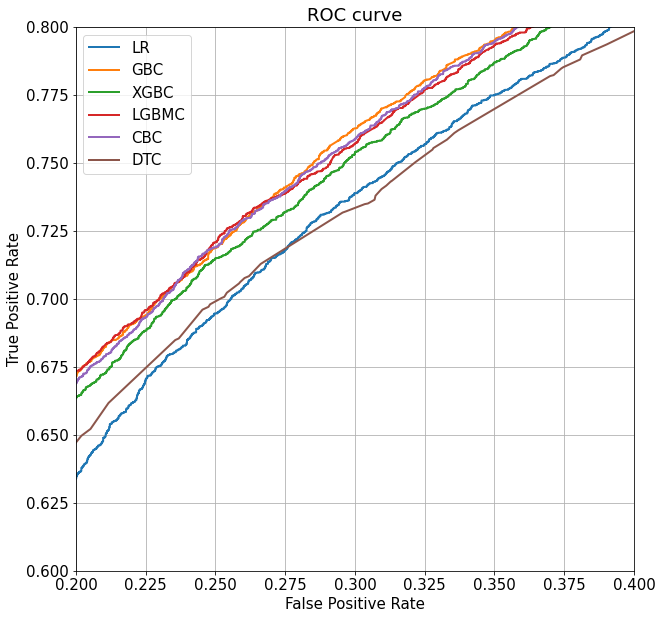

In [14]:
plt.figure(figsize=(10, 10))

fpr_LR, tpr_LR, thresholds_LR = roc_curve(y_test, y_score_LR, pos_label=1)
fpr_GBC, tpr_GBC, thresholds_GBC = roc_curve(y_test, y_score_GBC, pos_label=1)
fpr_XGBC, tpr_XGBC, thresholds_XGBC = roc_curve(y_test, y_score_XGBC, pos_label=1)
fpr_LGBMC, tpr_LGBMC, thresholds_LGBMC = roc_curve(y_test, y_score_LGBMC, pos_label=1)
fpr_CBC, tpr_CBC, thresholds_CBC = roc_curve(y_test, y_score_CBC, pos_label=1)
fpr_DTC, tpr_DTC, thresholds_DTC = roc_curve(y_test, y_score_DTC, pos_label=1)
lw = 2

plt.plot(fpr_LR, tpr_LR, lw=lw, label='LR')
plt.plot(fpr_GBC, tpr_GBC, lw=lw, label='GBC')
plt.plot(fpr_XGBC, tpr_XGBC, lw=lw, label='XGBC')
plt.plot(fpr_LGBMC, tpr_LGBMC, lw=lw, label='LGBMC')
plt.plot(fpr_CBC, tpr_CBC, lw=lw, label='CBC')
plt.plot(fpr_DTC, tpr_DTC, lw=lw, label='DTC')
plt.plot([0, 1], [0, 1])
plt.xlim([0.2, 0.4])
plt.ylim([0.6, 0.8])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend()
plt.savefig("ROC.jpg")
plt.grid()
plt.show()

#### Task № 4: Cделать выводы о том, какая модель справилась с задачей лучше других.

Лучше всего с задачей справились: 
- gradient boosting classifier; 
- Cat boost classifier;
- light gradient boosted machine classifier.

Лучший из них: $ Gradient  Boosting  Classifier $

GBC CV score with scoring='roc_auc_ovo' is 0.8023377962657184+-0.004150757612691979

GBC Best Threshold=0.394947, F-Score=0.740, Precision=0.698, Recall=0.788

#### Task № 5*: Какая метрика (precision_recall_curve или roc_auc_curve) больше подходит в случае сильного дисбаланса классов? (когда объектов одного из классов намного больше чем другого).

_Precision_recall_curve_ выделяет количество ложных срабатываний по отношению к размеру класса, тогда как _roc_auc_curve_ лучше отражает общее количество ложных срабатываний независимо от того, к какому классу они относятся (и соответсвенно более чувствительна в случае сильного дисбаланса классов). Сказать точно какая лучше нельзя, все зависит от условия задачи (в медецинских задачах зачастую бывают важны только сами ложные срабатывания и при этом абсолютно без разницы к какому классу они относятся).

#### Task № 6*: Найти порог классификации по деньгам (Стоимость лечения 15000 р, если сделали тест и начали лечить вовремя. Стоимость лечения 20000, если упустили и начали лечить когда уже проявились все симптомы. Стоимость теста 1400 р)

In [15]:
TN = cnf_matrix[1][0][0]
FN = cnf_matrix[1][1][0]
TP = cnf_matrix[1][1][1]
FP = cnf_matrix[1][0][1]

TPR = TP/(TP+FN)
FPR = FP/(FP+TN)
TNR = TN/(FP+TN)
TPR, FPR, TNR

(0.7880184331797235, 0.33582766439909295, 0.664172335600907)

33,6 % всех пациентов получат метку 1 при том, что они на самом деле здоровы

#### Пусть:
 - стоимость лечения 15000 р, если сделали тест и начали лечить вовремя
 - стоимость лечения 20000, если упустили и начали лечить когда уже проявились все симптомы 
 - стоимость теста 1400 р
 
 
 
 - лишних тестов сделали FP = cnf_matrix[1][0][1]
 - пропустили больных FN = cnf_matrix[1][1][0]
 - правильных тестов сделали TP = cnf_matrix[1][1][1]

Оценим расходы, если не делать тест и ждать симптомов:

In [16]:
rubl_to_test = 1400
rubl_to_early_treatment = 15000
rubl_to_late_treatment = 20000

In [17]:
rubl_1 = (cnf_matrix[1][1][0]+cnf_matrix[1][1][1]) * rubl_to_late_treatment
print('расходы, если не делать тест и ждать симптомов:',rubl_1)

расходы, если не делать тест и ждать симптомов: 173600000


In [18]:
rubl_all_test = np.sum(cnf_matrix[1]) * rubl_to_test + (cnf_matrix[1][1][0]+cnf_matrix[1][1][1]) * rubl_to_early_treatment
print('расходы, если делать тест всем и лечить группу большых:',rubl_all_test)

расходы, если делать тест всем и лечить группу большых: 154700000


In [19]:
rubl_ML = (cnf_matrix[1][0][1]+cnf_matrix[1][1][1]) * rubl_to_test + \
          (cnf_matrix[1][1][0]) * rubl_to_late_treatment + np.sum(cnf_matrix[1][1][1]) * rubl_to_early_treatment
print('расходы, если не делать тест и ждать симптомов и использовать ML:',rubl_ML)

расходы, если не делать тест и ждать симптомов и использовать ML: 153122800


In [20]:
def business_threshold_calibrate(y_test, y_score, thresholds,rubl_to_test = 100, 
                                 rubl_to_early_treatment = 100, rubl_to_late_treatment = 1000):
    business_threshold = 0
    r1_r2_ = 0
    r1_r3_ = 0
    r2_r3_ = 0
    rubl_1_ = - 10000000 
    rubl_all_test_ = - 10000000 
    rubl_ML_ = - 10000000 

    r2 = []
    n = 20
    for opt_buisness_tr in np.linspace(0,1,n).tolist():
        # подберем порог для улучшения бизнесс показателя

        cnf_matrix = confusion_matrix(y_test, y_score > ( opt_buisness_tr))
        #print(cnf_matrix )
        rubl_1 = ((cnf_matrix[1][1]+cnf_matrix[1][0])) * rubl_to_late_treatment

        rubl_all_test = np.sum(cnf_matrix) * rubl_to_test + \
                        ((cnf_matrix[1][0]+cnf_matrix[1][1])) * rubl_to_early_treatment

        rubl_ML = ((cnf_matrix[1][1]+cnf_matrix[0][1])) * rubl_to_test + \
                    np.sum(cnf_matrix[1][0]) * rubl_to_late_treatment + \
                    (cnf_matrix[1][1]) * rubl_to_early_treatment
       
        r2_r3 = rubl_all_test - rubl_ML 
        
        r1_r2 = rubl_1 - rubl_all_test
        r1_r3 = rubl_1 - rubl_ML
        #print(opt_buisness_tr, r2_r3)
        if (r2_r3_ < r2_r3):
            
            business_threshold = opt_buisness_tr
            r1_r2_ = r1_r2
            r1_r3_ = r1_r3
            r2_r3_ = r2_r3
            rubl_1_ = rubl_1
            rubl_all_test_ = rubl_all_test
            rubl_ML_ = rubl_ML
            
        r2.append(r2_r3)   
            
    
    print('расходы, если не делать тест и ждать симптомов:',rubl_1_)
    print('расходы, если делать тест всем и лечить группу большых:',rubl_all_test_)
    print('расходы, если не делать тест и ждать симптомов:',rubl_ML_)
    print(' Расходы при решении не делать тесты - расходы с МL :',r1_r3_ )
    print(' Расходы при решении не делать тесты - расходы ссделать тесты всем  :',r1_r2_ )
    print(' Расходы сделать тесты всем - решение делать тесты ML  :',r2_r3_ )
    plt.plot(np.linspace(0,1,n),r2)
    plt.grid()
    plt.show()
    return business_threshold
    

расходы, если не делать тест и ждать симптомов: 173600000
расходы, если делать тест всем и лечить группу большых: 154700000
расходы, если не делать тест и ждать симптомов: 152333600
 Расходы при решении не делать тесты - расходы с МL : 21266400
 Расходы при решении не делать тесты - расходы ссделать тесты всем  : 18900000
 Расходы сделать тесты всем - решение делать тесты ML  : 2366400


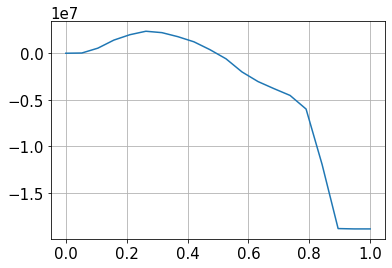

уровень порога по бизнес метрике 0.2631578947368421
уровень порога по f1 метрике 0.39494659702686624


In [21]:
BUisnes_tr = business_threshold_calibrate(y_test, y_score_GBC, 
                                          t_GBC,
                                          rubl_to_test = 1400, 
                                          rubl_to_early_treatment = 15000, 
                                          rubl_to_late_treatment = 20000)
print('уровень порога по бизнес метрике',BUisnes_tr)
print('уровень порога по f1 метрике',t_GBC)

расходы, если не делать тест и ждать симптомов: 173600000
расходы, если делать тест всем и лечить группу большых: 154700000
расходы, если не делать тест и ждать симптомов: 152326600
 Расходы при решении не делать тесты - расходы с МL : 21273400
 Расходы при решении не делать тесты - расходы ссделать тесты всем  : 18900000
 Расходы сделать тесты всем - решение делать тесты ML  : 2373400


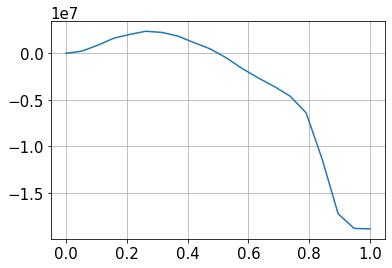

уровень порога по бизнес метрике 0.2631578947368421
уровень порога по f1 метрике 0.36976892597281524


In [22]:
BUisnes_tr = business_threshold_calibrate(y_test, y_score_CBC, 
                                          t_CBC,
                                          rubl_to_test = 1400, 
                                          rubl_to_early_treatment = 15000, 
                                          rubl_to_late_treatment = 20000)
print('уровень порога по бизнес метрике',BUisnes_tr)
print('уровень порога по f1 метрике',t_CBC)

расходы, если не делать тест и ждать симптомов: 173600000
расходы, если делать тест всем и лечить группу большых: 154700000
расходы, если не делать тест и ждать симптомов: 152388000
 Расходы при решении не делать тесты - расходы с МL : 21212000
 Расходы при решении не делать тесты - расходы ссделать тесты всем  : 18900000
 Расходы сделать тесты всем - решение делать тесты ML  : 2312000


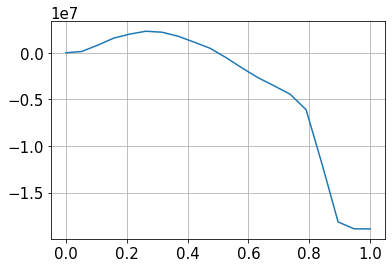

уровень порога по бизнес метрике 0.2631578947368421
уровень порога по f1 метрике 0.3447966167909033


In [23]:
BUisnes_tr = business_threshold_calibrate(y_test, y_score_LGBMC, 
                                          t_LGBMC,
                                          rubl_to_test = 1400, 
                                          rubl_to_early_treatment = 15000, 
                                          rubl_to_late_treatment = 20000)
print('уровень порога по бизнес метрике',BUisnes_tr)
print('уровень порога по f1 метрике',t_LGBMC)

расходы, если не делать тест и ждать симптомов: 173600000
расходы, если делать тест всем и лечить группу большых: 154700000
расходы, если не делать тест и ждать симптомов: 152707200
 Расходы при решении не делать тесты - расходы с МL : 20892800
 Расходы при решении не делать тесты - расходы ссделать тесты всем  : 18900000
 Расходы сделать тесты всем - решение делать тесты ML  : 1992800


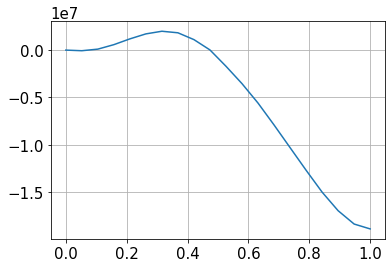

уровень порога по бизнес метрике 0.3157894736842105
уровень порога по f1 метрике 0.3861330543682467


In [24]:
BUisnes_tr = business_threshold_calibrate(y_test, y_score_LR, 
                                          t_LR,
                                          rubl_to_test = 1400, 
                                          rubl_to_early_treatment = 15000, 
                                          rubl_to_late_treatment = 20000)
print('уровень порога по бизнес метрике',BUisnes_tr)
print('уровень порога по f1 метрике',t_LR)

расходы, если не делать тест и ждать симптомов: 173600000
расходы, если делать тест всем и лечить группу большых: 154700000
расходы, если не делать тест и ждать симптомов: 152509800
 Расходы при решении не делать тесты - расходы с МL : 21090200
 Расходы при решении не делать тесты - расходы ссделать тесты всем  : 18900000
 Расходы сделать тесты всем - решение делать тесты ML  : 2190200


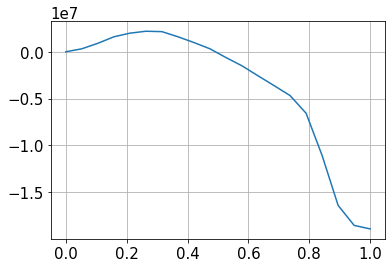

уровень порога по бизнес метрике 0.2631578947368421
уровень порога по f1 метрике 0.34710324


In [25]:
BUisnes_tr = business_threshold_calibrate(y_test, y_score_XGBC, 
                                          t_XGBC,
                                          rubl_to_test = 1400, 
                                          rubl_to_early_treatment = 15000, 
                                          rubl_to_late_treatment = 20000)
print('уровень порога по бизнес метрике',BUisnes_tr)
print('уровень порога по f1 метрике',t_XGBC)

расходы, если не делать тест и ждать симптомов: 173600000
расходы, если делать тест всем и лечить группу большых: 154700000
расходы, если не делать тест и ждать симптомов: 153121200
 Расходы при решении не делать тесты - расходы с МL : 20478800
 Расходы при решении не делать тесты - расходы ссделать тесты всем  : 18900000
 Расходы сделать тесты всем - решение делать тесты ML  : 1578800


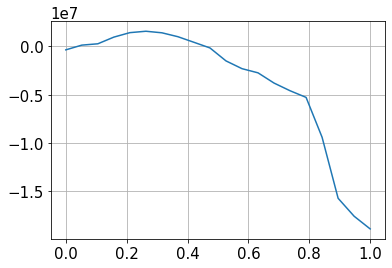

уровень порога по бизнес метрике 0.2631578947368421
уровень порога по f1 метрике 0.32


In [26]:
BUisnes_tr = business_threshold_calibrate(y_test, y_score_DTC, 
                                          t_DTC,
                                          rubl_to_test = 1400, 
                                          rubl_to_early_treatment = 15000, 
                                          rubl_to_late_treatment = 20000)
print('уровень порога по бизнес метрике',BUisnes_tr)
print('уровень порога по f1 метрике',t_DTC)

#### Здесь видно что лучше всего с задачей справился DecisionTreeClassifier